### 1. Loading required packages: 

In [1]:
# Basics: 
import numpy as np
import pandas as pd


# For text cleaning & sentiment analysis:
## nltk imports
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
## spacy imports
import spacy
import en_core_web_sm
sp = spacy.load('en_core_web_sm')
nlp = en_core_web_sm.load()

## vectorizer
from sklearn.feature_extraction.text import CountVectorizer
## sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# For classification: 
import tensorflow

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
pd.set_option('display.max_columns',500)
pd.set_option('display.width',500)

### 2. Loading Data: 

In [3]:
raw = pd.read_csv('C:\\Users\Sanha Tahir\\Downloads\\GeorgeTown\\General-Code-Data\\SPAM text message 20170820 - Data.csv')
raw

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


### 3. Cleaning data and removing named entities for analysis:

In [4]:
list_stopwords = stopwords.words("english")


def cleaning_msg(msg):
    
    # Initializing stemmer 
    snow = SnowballStemmer("english")
    
    # Converting to lower case:
    msg_lower = msg.lower()
    
    # Getting named eintities:
    raw_nlp = nlp(msg_lower)
    
    # Initializing empty list for named eintities:
    list_ne = []
    
    # Adding all names entities into list:
    for one_ents in raw_nlp.ents:
        list_ne.append(one_ents.text)
    
    # Tokenizing words:
    msg_tokens = word_tokenize(msg_lower)
    
    # Removing named entities:
    non_ne = [wrd for wrd in msg_tokens if wrd not in list_ne]
    
    # 3. Removing stopwords, non-alphabet words and smol words 
    msg_cl_tk = [snow.stem(wrd) for wrd in non_ne
                if wrd not in list_stopwords
                and wrd.isalpha()
                and len(wrd) >= 4]
    
    
    # Joining everything:
    msg_final = (" ".join(msg_cl_tk))
    
    return msg_final

raw["processed_msg"] = [ cleaning_msg(msg) for msg in raw["Message"]]
raw[["Message", "processed_msg"]].head(n = 5)

,Message,processed_msg
0,"Go until jurong point, crazy.. Available only ...",jurong point crazi avail bugi great world buff...
1,Ok lar... Joking wif u oni...,joke
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp final tkts text receiv en...
3,U dun say so early hor... U c already then say...,earli alreadi
4,"Nah I don't think he goes to usf, he lives aro...",think goe live around though


### 3. Performing sentiment analysis using VADER:

In [5]:
## Defining Function:

def sent_vader(processed_msg):
   
    # Initializing a scorer
    sent_obj = SentimentIntensityAnalyzer()
    
    # Scoring sentiment:
    sentiment_scores = sent_obj.polarity_scores(processed_msg)
    
    # Adding contents:
    # sentiment_example["contents"] = raw
    
    return(sentiment_scores['compound'])


raw["vader_compounded_score"] = [sent_vader(msg) for msg in raw["processed_msg"]]
raw.head(n = 5)
# # Applying Function:
# print("Starting ftn: " + str(pd.Timestamp.now()))
# rez = [one_3b(raw) for raw in doj_subset["contents"]]
# print("Ending ftn: " + str(pd.Timestamp.now()))

,Category,Message,processed_msg,vader_compounded_score
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazi avail bugi great world buff...,0.8442
1,ham,Ok lar... Joking wif u oni...,joke,0.2960
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp final tkts text receiv en...,0.5106
3,ham,U dun say so early hor... U c already then say...,earli alreadi,0.0000
4,ham,"Nah I don't think he goes to usf, he lives aro...",think goe live around though,0.0000


In [6]:
# Creating a binary variable for positive or not:
raw['positive'] = raw.vader_compounded_score.apply(lambda x: 0 if x < 0.5 else 1)
raw.head()

,Category,Message,processed_msg,vader_compounded_score,positive
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazi avail bugi great world buff...,0.8442,1
1,ham,Ok lar... Joking wif u oni...,joke,0.2960,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp final tkts text receiv en...,0.5106,1
3,ham,U dun say so early hor... U c already then say...,earli alreadi,0.0000,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",think goe live around though,0.0000,0


### 4. Sentiment analysis using TensorFlow:

In [7]:
# Importing packages:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.utils import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, GlobalAveragePooling1D

### 5. Create model:

In [8]:
# Splitting data into training (80) and testing ()20
split = round(len(raw)*0.8)
train_reviews = raw['processed_msg'][:split]
train_label = raw['positive'][:split]
test_reviews = raw['processed_msg'][split:]
test_label = raw['positive'][split:]

# Setting parameters: 
vocab_size = 40000      # 40,000 unique words to train the network
embedding_dim = 16      # Each word will be represented in 16 dimensions
max_length = 120        # Max length of each message 
trunc_type = 'post'     # Truncates after 120 words 
oov_tok = '<OOV>'       # Replace out-of-sequence words
padding_type = 'post'   # Padding is added at end to make all 120 words 


# Tokenizing training messages :
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_reviews)
word_index = tokenizer.word_index

# Representing (training) messages into sequence of integers: 
sequences = tokenizer.texts_to_sequences(train_reviews)

# Pad training & testing messages, if necessary 
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

training_sentences = tokenizer.texts_to_sequences(train_reviews)
training_padded = pad_sequences(training_sentences , maxlen = max_length)
    
testing_sentences = tokenizer.texts_to_sequences(test_reviews)
testing_padded = pad_sequences(testing_sentences, maxlen = max_length)


# Creating model!
# A sequential model that builds layers on top of another
model = Sequential([      
    Embedding(vocab_size, embedding_dim, input_length=max_length), # Embedding the forst layer using the parameters already decided
    GlobalAveragePooling1D(),                                     # Flattening the vector from 3D 
    Dense(6, activation='relu'),                                  # Hidden layer with 6 neurons
    Dense(1, activation='sigmoid')                                # last layer in a classification problem is always sigmoid or softmax
])


# Compiling model:
model.compile(loss='binary_crossentropy',     # 
              optimizer='adam',               # Optimizing method 
              metrics=['accuracy']            # The metric we want to calculate 
             ) 


# Printing model summary: 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           640000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 640,109
Trainable params: 640,109
Non-trainable params: 0
_________________________________________________________________


<div class = 'alert alert-block alert-warning'>
1. <b> Embedding layer:  </b> No batc size; messages of length 120 of 16 dimensions  <br>
2. <b> Flattening </b> to 1 dimension  <br>
3. <b> No batch size </b> - only numner of features (6 & then 1)
    </div>

### 6. Training model: 

In [9]:
training_labels_final = np.array(train_label)
testing_labels_final = np.array(test_label)

print(testing_padded.shape)
print(testing_labels_final.shape )

num_epochs = 20
history = model.fit(padded, 
                    training_labels_final, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels_final))

(1114, 120)
(1114,)
Epoch 1/20
140/140 [==============================] - 5s 20ms/step - loss: 0.6016 - accuracy: 0.7775 - val_loss: 0.5171 - val_accuracy: 0.7980
Epoch 2/20
140/140 [==============================] - 2s 17ms/step - loss: 0.5012 - accuracy: 0.7954 - val_loss: 0.4926 - val_accuracy: 0.7980
Epoch 3/20
140/140 [==============================] - 2s 17ms/step - loss: 0.4940 - accuracy: 0.7954 - val_loss: 0.4897 - val_accuracy: 0.7980
Epoch 4/20
140/140 [==============================] - 2s 16ms/step - loss: 0.4905 - accuracy: 0.7954 - val_loss: 0.4866 - val_accuracy: 0.7980
Epoch 5/20
140/140 [==============================] - 2s 17ms/step - loss: 0.4864 - accuracy: 0.7954 - val_loss: 0.4824 - val_accuracy: 0.7980
Epoch 6/20
140/140 [==============================] - 2s 17ms/step - loss: 0.4807 - accuracy: 0.7954 - val_loss: 0.4769 - val_accuracy: 0.7980
Epoch 7/20
140/140 [==============================] - 2s 17ms/step - loss: 0.4732 - accuracy: 0.7954 - val_loss: 0.4692 - 

<div class = 'alert alert-block alert-warning'>
<b> Training accuracy </b>  = 94.01%   <br>
<b> Validation accuracy </b> = 90.58% 
    </div>

<Figure size 640x480 with 0 Axes>

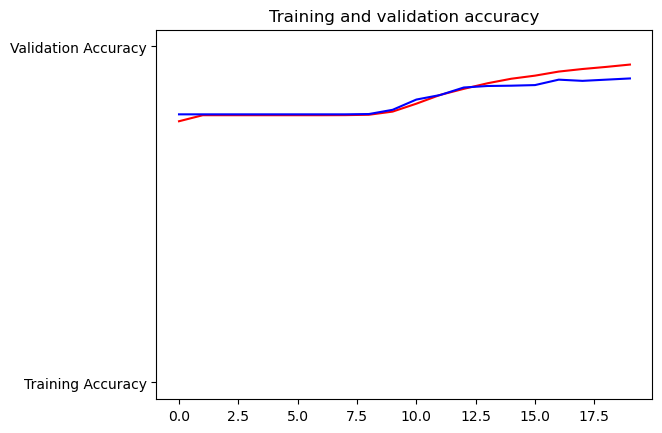

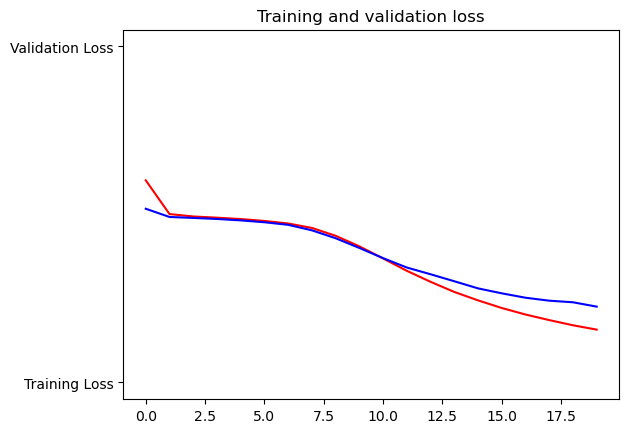

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()

In [11]:

from keras.utils import plot_model

dot_img_file = 'model_1.png'
plot_model(model, to_file=dot_img_file, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
import pydot
import graphviz 

In [13]:
# Spam analysis using Keras: 